# Todo:

- kruskal-wallis test for cases of multiple location tests
- update test for using ranks (some stats tests are not ranked yet...starting from the acral module)


# Setup

In [31]:
%%capture

###############################################
###############################################
# Setup
# This chuck ingests pre-computed variables
###############################################
###############################################

# [Shift + Return] to run chunks 

###############################################

# settings
wkdir, s3dir = '/home/ubuntu/data/DL20181011_melanocyte_test_data', 'daniel.le-work/MEL_project'

%reload_ext autoreload
%autoreload 2
from scanpy_helpers import *
warnings.filterwarnings('ignore')
%matplotlib inline

# import data from s3
for file in ['adata_subset1', 'adata_subset2', 'full_adata', 'pre_adata','adata_subset1_KRT','raw_adata']:
#     ! aws s3 cp s3://{s3dir}/{file}.p {wkdir}/
    var = pickle.load((open(f'{wkdir}/{file}.p', 'rb')))
    exec(f'{file} = var')
    del var

# FUNCTIONS
from collections import defaultdict
import multiprocessing

def single_mwu(args):    
    # inputs
    gene_val, df1, df2, alt = args
    
    try:
        stat, pval = stats.mannwhitneyu(df1[gene_val].values,
                                        df2[gene_val].values, 
                                        alternative = alt
                                       )
    except:
        stat = np.nan
        pval = np.nan
    return (stat, pval)

def parallel_mwu(genes, df1, df2, method='two-sided', ncores=1):
    
    p = multiprocessing.Pool(processes=ncores)
    try:
        mwu_tuples = p.map(single_mwu, 
                                zip(genes,
                                    [df1]*len(genes),
                                    [df2]*len(genes),
                                    [method]*len(genes)
                                   ), 
                                chunksize=100)
    finally:
        p.close()
        p.join()

    stat_list = [x[0] for x in mwu_tuples]
    pval_list = [x[1] for x in mwu_tuples]
    return (stat_list, pval_list)
    

def single_ranks(args):    
    # inputs
    ## df1 = single cell df 
    df1_row, df1, df2 = args
    
    # filter by nonzero expressing genes in single cell and rank
    return_genes = []
    return_ranks = []
    for df2_row in range(len(df2)):
        keep_idx = df1.iloc[df1_row,:].values > 0
        gene_vals = np.array(df1.columns)[keep_idx].tolist()
        df1_vals = stats.rankdata(df1.iloc[df1_row,:].values[keep_idx])
        df2_vals = stats.rankdata(df2.iloc[df2_row,:].values[keep_idx])
        rank_diff_vals = abs(df1_vals - df2_vals).tolist()
        
        return_genes = return_genes + gene_vals
        return_ranks = return_ranks + rank_diff_vals
    
    return (return_genes, return_ranks)

def parallel_ranks(df1, df2, ncore = 1):

    rank_diff_dict = defaultdict(list)
    p = multiprocessing.Pool(processes=ncore)
    jobs_list = [x for x in range(len(df1))]

    try:
        rank_tuples = p.map(single_ranks, 
                            zip(jobs_list,
                                [df1]*len(jobs_list),
                                [df2]*len(jobs_list)
                               ), 
                                chunksize=100)
    finally:
        p.close()
        p.join()
        
    for x in rank_tuples:
        genes = x[0]
        ranks = x[1]
        for gene,rank in zip(genes, ranks):
            rank_diff_dict[gene].append(rank)
            
    for key,value in rank_diff_dict.items():
        rank_diff_dict[key] = np.median(value) 
        
    genes = [key for key,value in rank_diff_dict.items()]
    rank_diffs = [value for key,value in rank_diff_dict.items()]
            
    return (genes, rank_diffs)

def parallel_paired_spearman(args):
        ### needs refactor ###
    # reference df  MUST be single cell in order to filter on nonzero expressing genes
    
    # inputs
    ref_idx, ref_df, cross_df, nonzero_only = args

    # slice df
    ref_slice = ref_df.iloc[ref_idx,:]
    if nonzero_only == True:
        ref_slice = ref_slice[ref_slice > 0]
    else:
        pass
    ref_values = ref_slice.values
    ref_cols = ref_slice.index.tolist()
    cross_slice = cross_df.loc[:,ref_cols]
    
    stat_list = []
    pval_list = []
    for i in range(len(cross_slice)):
        cross_values = cross_slice.iloc[i,:].values
        try:
            stat, pval = stats.spearmanr(ref_values,cross_values)
        except:    
            stat = pval = np.nan
        stat_list.append(stat)
        pval_list.append(pval)

    return (stat_list, pval_list)

# update KRT labels
adata_subset1_KRT.obs['dev_stage'] = ['adt' if x > 0 else 'neo' if x == 0 else 'fet' for x in adata_subset1_KRT.obs.age]
adata_subset1_KRT.obs['subtypes'] = [x if x in ['acral','foreskin'] else 'cutaneous' for x in adata_subset1_KRT.obs.general_location]
adata_subset1_KRT.obs['dev_subtype'] = [f'{x}_{y}' for x,y in zip(adata_subset1_KRT.obs.dev_stage, adata_subset1_KRT.obs.subtypes)]

for i in ['dev_stage', 'subtypes', 'dev_subtype']:
    adata_subset1_KRT.obs[i] =  (adata_subset1_KRT
                                 .obs[i]
                                 .astype(str)
                                 .astype(CategoricalDtype(list(set(adata_subset1_KRT.obs[i]))))
                                )
    


# Figure 1
High-level overview of data and analysis directions

## Gene module UMAPs: MEL vs KRT

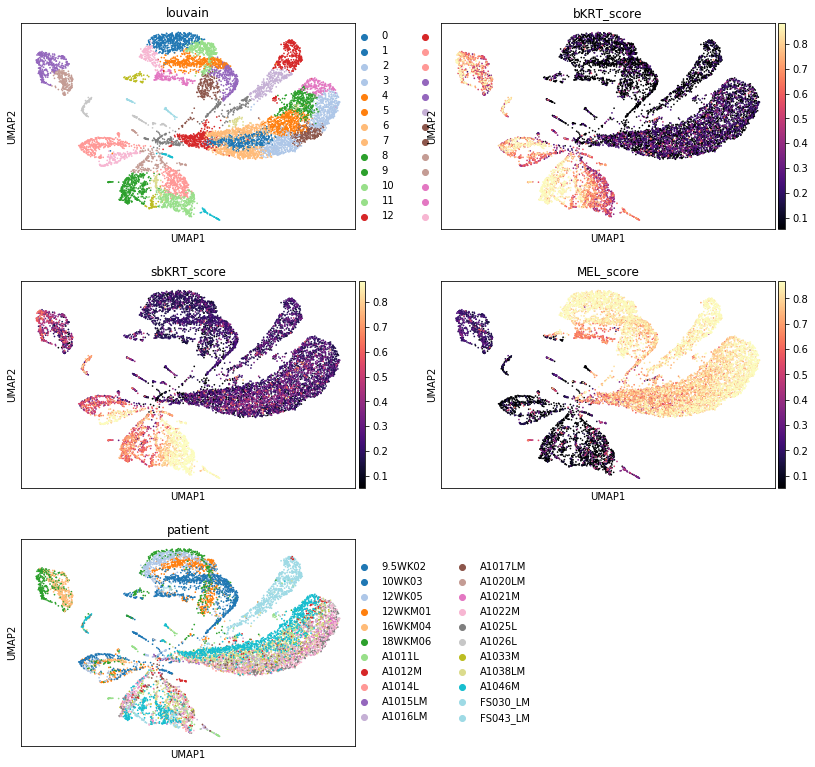

In [33]:
#SORT_module = ['ITGA6','KIT','ITGAX']
MEL_module = ['PMEL','TYR','DCT','MITF','TYRP1','SOX10']
bKRT_module = ['ITGB4','KRT14','KRT5','DSC3']
sbKRT_module = ['KRT1','KRT10','DSG1','DSC3']
cycling_module = ['TOP2A','CDK1','UBE2C','HIST1H4E','HIST1H4C'] # ref: https://www.biorxiv.org/content/biorxiv/early/2019/02/03/526848.full.pdf
## high = G2/M, low = G1/S

test_adata = full_adata
test_adata.obs['cell'] = test_adata.obs.index.tolist()
test_adata.obs['cell'] = (test_adata
                          .obs['cell']
                          .astype(str)
                          .astype(CategoricalDtype(test_adata.obs['cell'].tolist())))
cat, exp_df = prepare_dataframe(test_adata,
                 var_names = MEL_module+bKRT_module+sbKRT_module+cycling_module,
                 groupby = 'cell')
exp_df = exp_df.rank(pct=True, axis=0, method = 'min') # ranked expression per cell
exp_df = exp_df.rank(pct=True, axis=1, method = 'min') # ranking ranked expression per gene

test_adata.obs['MEL_score'] = exp_df.loc[:,MEL_module].mean(axis=1)
test_adata.obs['bKRT_score'] = exp_df.loc[:,bKRT_module].mean(axis=1)
test_adata.obs['sbKRT_score'] = exp_df.loc[:,sbKRT_module].mean(axis=1)
test_adata.obs['cycling_score'] = exp_df.loc[:,cycling_module].mean(axis=1)

sc.pl.umap(test_adata, color=['louvain','bKRT_score','sbKRT_score','MEL_score','patient'], 
           ncols = 2, cmap = 'magma', palette = 'tab20')


## Gene module heatmaps: MEL vs KRT

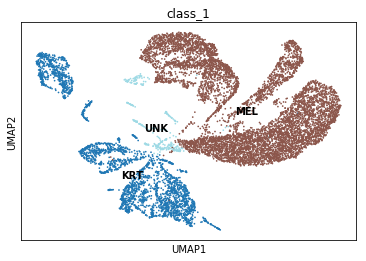

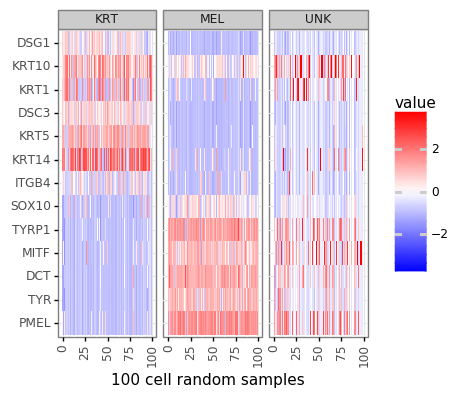

<ggplot: (8774390579464)>


In [35]:
# scaled heatmap to zero mean and unit variance
from sklearn.preprocessing import scale

cat, exp_df = prepare_dataframe(test_adata,
                 var_names = MEL_module+bKRT_module+sbKRT_module,
                 groupby = 'cell')
exp_df = exp_df.apply(lambda x: scale(x.values), axis = 1, result_type='broadcast')

exp_df['cell_type'] = test_adata.obs.class_1.tolist()
# sample 100 cells from each cell_type cluster
exp_df_melt = pd.melt((exp_df
                       .groupby('cell_type')
                       .apply(lambda x: (x.sample(100)
                                         .assign(idx = lambda x: [i for i in range(len(x))])
                                        )
                             )
                      ), id_vars=['cell_type','idx']
                     )
exp_df_melt['module'] = ['MEL' if x in MEL_module else 'KRT' for x in exp_df_melt.variable]
gene_order = pd.Series(MEL_module+bKRT_module+sbKRT_module).drop_duplicates().tolist()
exp_df_melt['variable'] = (exp_df_melt['variable']
                           .astype(str)
                           .astype(CategoricalDtype(gene_order, ordered=True))
                          )

sc.pl.umap(test_adata, color=['class_1'], palette = 'tab20', legend_loc = 'on data')
print(ggplot(exp_df_melt)
      + theme_bw()
      + theme(axis_text_x = element_text(angle = 90))
      + geom_tile(aes('idx','variable',fill='value'))
      + facet_grid('~cell_type')
      + scale_fill_cmap('bwr', limits = [-exp_df_melt.value.values.max(),exp_df_melt.value.values.max()])
      + labs(x = '100 cell random samples', y = '')
     )


## supplemental: MEL outlier detection and annotation
- outlier detection by maximizing mean cycling score as function of IQR scalar threshold 


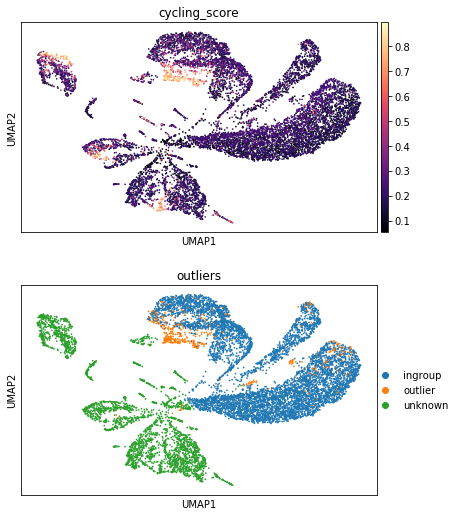

In [36]:
sc.pl.umap(full_adata, 
           color = ['cycling_score','outliers'], 
           ncols = 1,
           cmap = 'magma'
          )


## PCA identifies feature axes

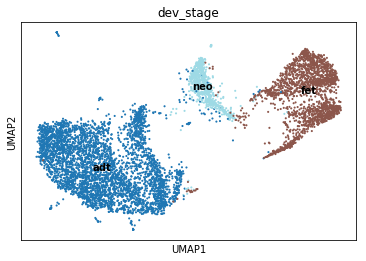

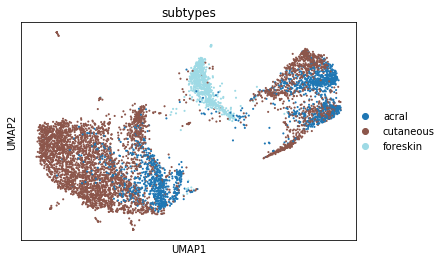

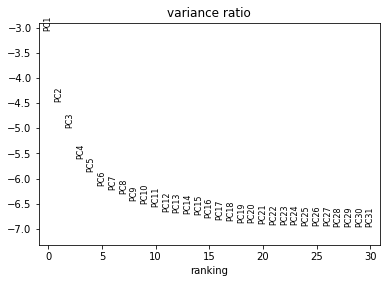

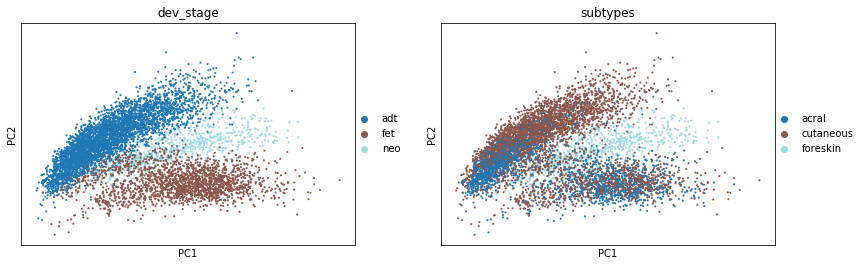

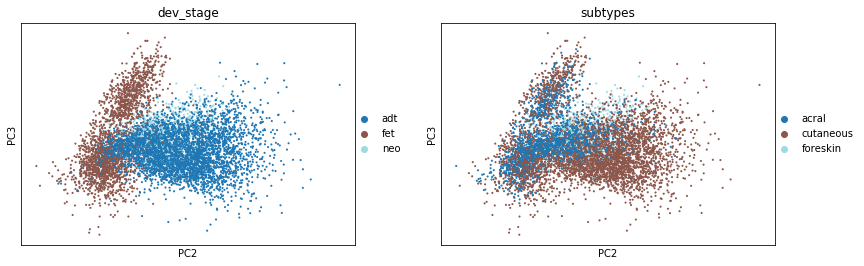

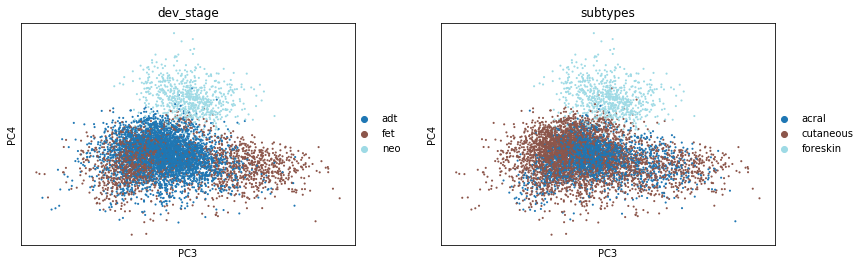

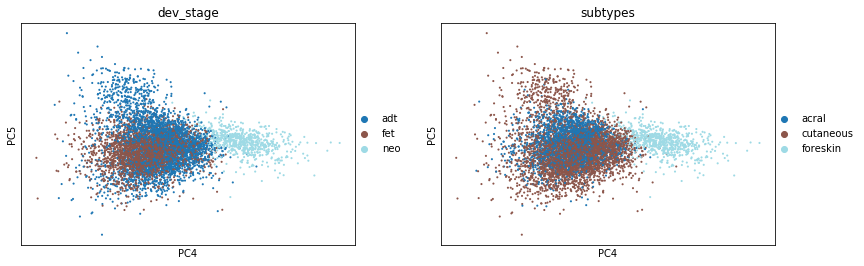

In [37]:
# simple output

adata_subset2.obs['dev_stage'] = ['adt' if x > 0 else 'neo' if x == 0 else 'fet' for x in adata_subset2.obs.age]
adata_subset2.obs['subtypes'] = [x if x in ['acral','foreskin'] else 'cutaneous' for x in adata_subset2.obs.general_location]
adata_subset2.obs['dev_subtype'] = [f'{x}_{y}' for x,y in zip(adata_subset2.obs.dev_stage, adata_subset2.obs.subtypes)]

sc.pl.umap(adata_subset2, color = ['dev_stage'],
          palette = 'tab20', legend_loc = 'on data')
sc.pl.umap(adata_subset2, color = ['subtypes'],
          palette = 'tab20')

features = ['dev_stage','subtypes']
sc.pl.pca_variance_ratio(adata_subset2, log=True)
sc.pl.pca(adata_subset2, components=['1,2'], color=features)
sc.pl.pca(adata_subset2, components=['2,3'], color=features)
sc.pl.pca(adata_subset2, components=['3,4'], color=features)
sc.pl.pca(adata_subset2, components=['4,5'], color=features)


###  supplemental: logistic regression for feature analysis using PC space


dev_stage
    PC        f1
0    1  0.705908
1    2  0.774767
2    3  0.651266
3    4  0.681031
4    5  0.582852
5    6  0.582852
6    7  0.582852
7    8  0.582852
8    9  0.582852
9   10  0.582852
10  11  0.582852
11  12  0.582852
12  13  0.582852
13  14  0.583296
14  15  0.582852


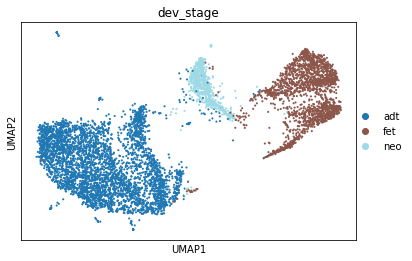

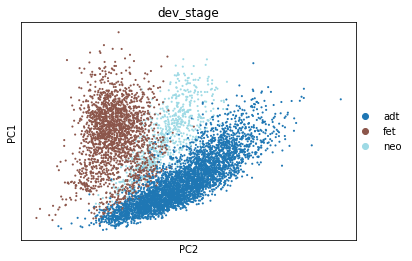

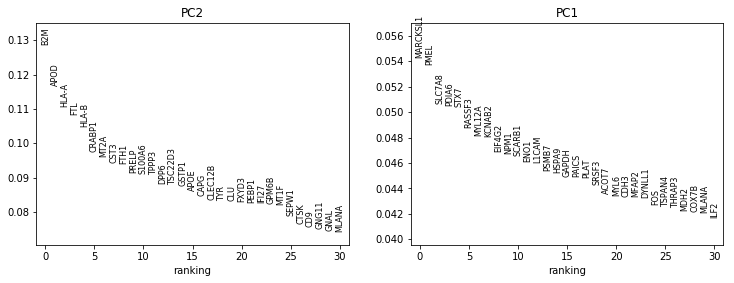

subtypes
    PC        f1
0    1  0.626388
1    2  0.653932
2    3  0.622834
3    4  0.723678
4    5  0.609951
5    6  0.647712
6    7  0.630386
7    8  0.665926
8    9  0.627721
9   10  0.628610
10  11  0.633940
11  12  0.624167
12  13  0.625944
13  14  0.629054
14  15  0.627721


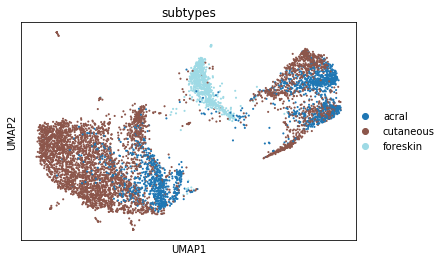

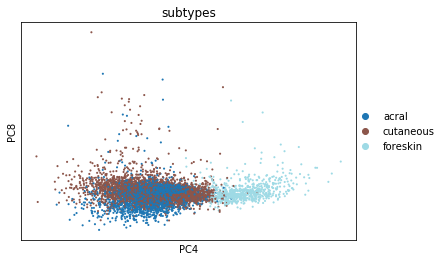

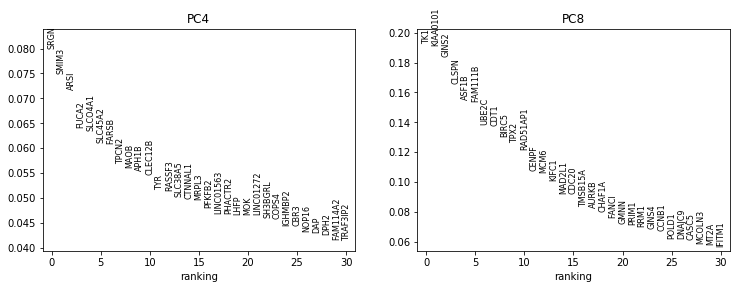

In [38]:
input_adata = adata_subset2

label_groups = ['dev_stage','subtypes']

for key in label_groups:
    print(key)
    results_list = []
    cell_list = input_adata.obs_names
    loc_list = input_adata.obs[key].values
    for PC in range(input_adata.obsm['X_pca'].shape[1]):
        PC_list = input_adata.obsm['X_pca'][:,PC]

        pred = PC_list # must be continuous
        res = np.array(loc_list) # must be categorical
        pred = pred.reshape(-1,1)
        res = res.reshape(-1,1)

        if len(np.unique(res)) == 1:
            acc = 0
        else:
            X_train, X_test, y_train, y_test = train_test_split(pred,
                                                                res,
                                                                test_size=0.33, 
                                                                random_state=42)
            # accurcy
            clf = LogisticRegression(multi_class='auto')
            clf.fit(X_train, y_train)
            y_pred = clf.predict(X_test)
            acc  = f1_score(y_true = y_test, 
                            y_pred = y_pred, 
                            average = 'micro')

            results_list.append(acc)
    log_df = pd.DataFrame({'PC':[x+1 for x in range(len(results_list))],
                           'f1':results_list})
    print(log_df.head(15))
    pcsOI = [x for x in log_df.sort_values('f1', ascending=False)['PC'][:2]]
    pc_coord = ','.join([str(x) for x in pcsOI])
    
    sc.pl.umap(input_adata, color=[key])
    sc.pl.pca(input_adata, components=[pc_coord], color=[key])
    sc.pl.pca_loadings(input_adata, components=pcsOI)
        

# Figure 2/3
Analysis of fetal vs adult

Analysis of age-related expression among fetal or adult

Analysis of cancer correlation

Analysis of acral-specific expression

## Adult vs. fetal differential expression

In [26]:
n_print = 10

input_adata = adata_subset2
# input_adata = adata_subset1_KRT
genes = adata_subset2.var_names.tolist()

cat, prep_slice = prepare_dataframe(input_adata,
                                 var_names = genes,
                                 groupby = 'dev_stage')

for i in ['greater', 'less']:
    print(f'fetal {i} than adult:')

    frac = 1
    n_uncert = 1
    while n_uncert > 0:
        
        fet_slice = (prep_slice[[x == 'fet' for x in prep_slice.index]]
                     .sample(frac=frac)
                     .rank(pct=True, axis = 1, method = 'min'))
        adt_slice = (prep_slice[[x == 'adt' for x in prep_slice.index]]
                     .sample(frac=frac)
                     .rank(pct=True, axis = 1, method = 'min'))

        print(f'Testing downsample fraction = {frac}')
        stat_pval_tuple = parallel_mwu(genes, 
                                   fet_slice, 
                                   adt_slice, 
                                   i, 
                                   15)
        stat_list = stat_pval_tuple[0]
        pval_list = stat_pval_tuple[1]
        results_df = pd.DataFrame({'gene':genes,
                                 'stat_1':stat_list,
                                 'pval_1':pval_list,
                                })
        results_df['frac'] = frac
        n_uncert = sum(results_df['pval_1'] == 0)
        frac /= 2
    print(f'downsample fraction: {frac}')

    display(results_df.dropna().sort_values('pval_1').head(10))


fetal greater than adult:
Testing downsample fraction = 1
Testing downsample fraction = 0.5
Testing downsample fraction = 0.25
downsample fraction: 0.125


,gene,stat_1,pval_1,frac
19317,SERPINF1,447855.5,4.253171e-249,0.25
12482,LYPD1,416963.0,4.322909e-234,0.25
20590,SOX11,411308.5,2.233313e-223,0.25
17753,PXDN,398060.0,8.634864e-190,0.25
3839,COL1A2,401737.0,2.193566e-169,0.25
2283,C3orf79,403168.0,4.804372e-159,0.25
8487,IGFBP3,376256.0,1.560508e-150,0.25
6598,FOS,411646.5,1.973363e-144,0.25
4046,CREB5,369799.5,6.683357e-136,0.25
12785,MCAM,354261.5,2.123747e-134,0.25


fetal less than adult:
Testing downsample fraction = 1
Testing downsample fraction = 0.5
Testing downsample fraction = 0.25
downsample fraction: 0.125


,gene,stat_1,pval_1,frac
1496,B2M,24377.0,3.869947e-165,0.25
968,APOD,29508.0,4.178543e-158,0.25
3044,CD59,32420.0,8.413209e-153,0.25
8012,HLA-B,41338.0,2.122735e-147,0.25
4025,CRABP1,49416.0,2.570420e-138,0.25
8011,HLA-A,46684.5,6.893407e-132,0.25
9737,LGALS3,48471.0,4.981388e-130,0.25
14366,MT2A,50595.0,2.214656e-128,0.25
8013,HLA-C,58747.0,8.231984e-119,0.25
22624,TSC22D3,73448.0,3.829533e-99,0.25


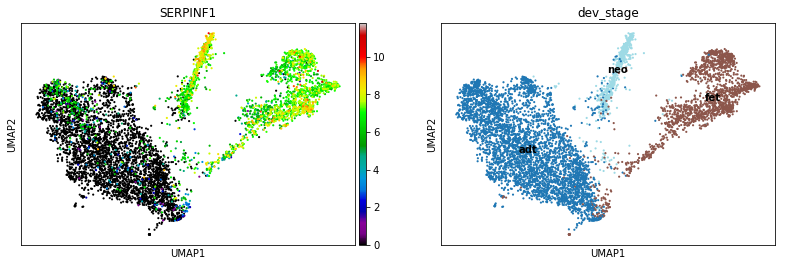

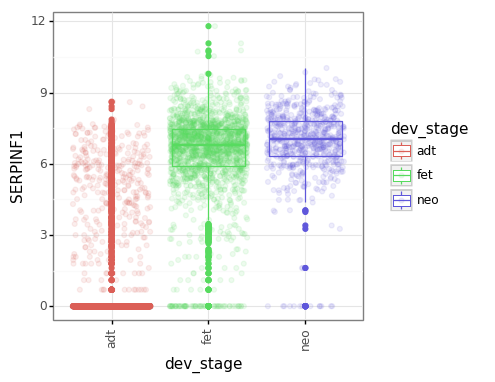

<ggplot: (8774199908016)>
querying 1-1...done.
Finished.
0:  SERPINF1 
 This gene encodes a member of the serpin family that does not display the serine protease inhibitory activity shown by many of the other serpin proteins. The encoded protein is secreted and strongly inhibits angiogenesis. In addition, this protein is a neurotrophic factor involved in neuronal differentiation in retinoblastoma cells. Mutations in this gene were found in individuals with osteogenesis imperfecta, type VI. [provided by RefSeq, Aug 2016].


In [8]:
# look up gene

gene = 'SERPINF1'
groupby = 'dev_stage'

sc.pl.umap(input_adata, color = [gene, groupby], cmap='nipy_spectral', palette = 'tab20', legend_loc = 'on data')

cat, plot_df = prepare_dataframe(input_adata,
                            gene,
                            groupby
                           )
plot_df = plot_df.reset_index()
plotnine.options.figure_size = (4,4)
print(ggplot(plot_df)
      + theme_bw()
      + theme(axis_text_x = element_text(angle = 90))
      + geom_boxplot(aes(groupby, gene, color = groupby))
      + geom_jitter(aes(groupby, gene, color = groupby), alpha = 0.1)
     )

out = symbol2field(gene)
output = [print(f'{idx}: ', 
       x['query'],
       '\n',x['summary']) if ('summary' in x.keys()) else print(f'{idx}: ', 
                                                                x['query'],
                                                                '\n','N/A') for idx, x in enumerate(out)]


## Acral-specific expression analysis

In [27]:
n_print = 10

# To isolate acral-specific expression, the union of age-independent genes 
#between acral and cutaneous gene sets are tested for differential expression

input_adata = adata_subset2
genes = adata_subset2.var_names.tolist()

# Which acral or cutanesous-specific genes are NOT significantly different between FET and ADT?
alpha = 0.05
adj_alpha = alpha / (len(genes) * 2)

type_specific_df = pd.DataFrame()
for subtype in ['acral', 'cutaneous']:
    slice_df = input_adata[[x == subtype for x in input_adata.obs.subtypes]]
    cat, prep_slice = prepare_dataframe(slice_df,
                                     var_names = genes,
                                     groupby = 'dev_stage')
    fet_splice = (prep_slice[[x == 'fet' for x in prep_slice.index]]
                  .rank(pct=True, axis = 1, method = 'min'))
    nfet_splice = (prep_slice[[x == 'adt' for x in prep_slice.index]]
                   .rank(pct=True, axis = 1, method = 'min'))

    stat_pval_tuple = parallel_mwu(genes, 
                               fet_splice, 
                               nfet_splice, 
                               'two-sided',
                               7)
    stat_list = stat_pval_tuple[0]
    pval_list = stat_pval_tuple[1]
    tmp_df = (pd.DataFrame({'gene':genes,
                             'stat_1':stat_list,
                             'pval_1':pval_list
                            })
              )
    tmp_df['subtypes'] = subtype
    tmp_df['pass'] = [x < adj_alpha for x in tmp_df['pval_1']]
    type_specific_df = type_specific_df.append(tmp_df)

testable = type_specific_df[type_specific_df['pass'] == False]['gene'].value_counts()
testable = testable[testable == 2]
testable = testable.index.tolist()

# Of the identified genes, which exhibit a significant difference between acral and cutaneous cell type

adj_alpha = alpha / ((len(genes) * 2) + len(testable))
cat, prep_slice = prepare_dataframe(input_adata,
                                     var_names = testable,
                                     groupby = 'subtypes')
prep_slice = prep_slice[prep_slice.index != 'foreskin']
cut_input = (prep_slice[[x == 'cutaneous' for x in prep_slice.index]]
             .rank(pct=True, axis = 1, method = 'min'))
acr_input = (prep_slice[[x == 'acral' for x in prep_slice.index]]
             .rank(pct=True, axis = 1, method = 'min'))

stat_pval_tuple = parallel_mwu(testable, 
                               cut_input, 
                               acr_input, 
                               'two-sided',
                               7)
stat_list = stat_pval_tuple[0]
pval_list = stat_pval_tuple[1]
diff_df = (pd.DataFrame({'gene':testable,
                         'stat_1':stat_list,
                         'pval_1':pval_list
                        })
          )
diff_df['pass'] = [x < adj_alpha for x in diff_df['pval_1']]
display(diff_df[diff_df['pass'] == True].sort_values('pval_1').head(n_print))


,gene,stat_1,pval_1,pass
5613,NTRK2,1869415.0,1.443227e-301,True
3494,ID2,1959244.0,9.618215e-160,True
11040,HPGD,4527789.5,1.019100e-88,True
9928,MCOLN3,4498859.5,4.418363e-77,True
11582,DMKN,4216823.0,1.963504e-60,True
3172,SHC4,3051972.5,2.137371e-35,True
3346,GSTP1,4075166.0,1.215948e-27,True
706,HOTAIRM1,3752624.0,1.837625e-26,True
6094,YWHAE,4109618.0,5.140035e-26,True
306,ATP5J2,2883889.0,3.256932e-25,True


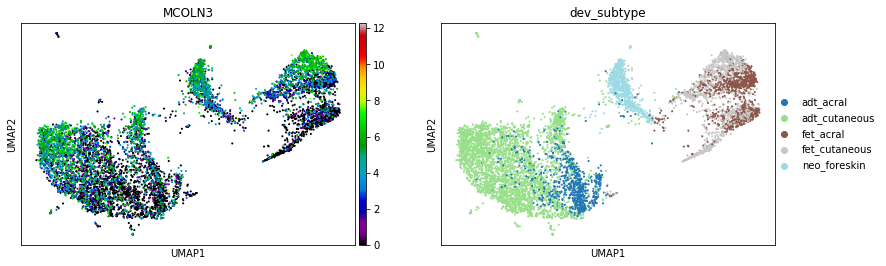

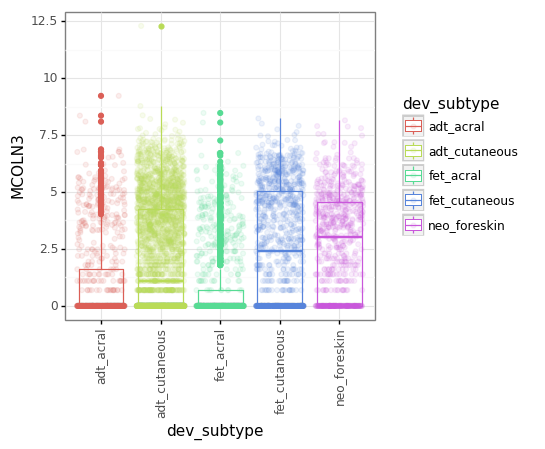

<ggplot: (-9223363262464173501)>
querying 1-1...done.
Finished.
0:  MCOLN3 
 This gene encodes one of members of the mucolipin cation channel proteins. Mutation studies of the highly similar protein in mice have shown that the protein is found in cochlea hair cells, and mutant mice show early-onset hearing loss and balance problems. Multiple transcript variants encoding different isoforms have been found for this gene. [provided by RefSeq, Nov 2011].


In [42]:
# look up gene

gene = 'MCOLN3'
groupby = 'dev_subtype'

sc.pl.umap(input_adata, color = [gene, groupby], cmap='nipy_spectral', palette = 'tab20')

cat, plot_df = prepare_dataframe(input_adata,
                            gene,
                            groupby
                           )
plot_df = plot_df.reset_index()
plotnine.options.figure_size = (4,4)
print(ggplot(plot_df)
      + theme_bw()
      + theme(axis_text_x = element_text(angle = 90))
      + geom_boxplot(aes(groupby, gene, color = groupby))
      + geom_jitter(aes(groupby, gene, color = groupby), alpha = 0.1)
     )

out = symbol2field(gene)
output = [print(f'{idx}: ', 
       x['query'],
       '\n',x['summary']) if ('summary' in x.keys()) else print(f'{idx}: ', 
                                                                x['query'],
                                                                '\n','N/A') for idx, x in enumerate(out)]


## Age rank correlations
Among fetal or adult samples. 

n_genes correlation computed for control.

In [28]:
n_print = 10
input_adata = adata_subset2
# input_adata = adata_subset1_KRT

input_adata.obs['true_year'] = [float(x.split('WK')[0])/52 if len(x.split('WK')[0]) <= 3 else np.nan for x in input_adata.obs.patient]
input_adata.obs['true_year'] = [y+(9/12) if np.isnan(x) else x for x,y in zip(input_adata.obs['true_year'], input_adata.obs['age']) ]

subpop = 'adult'
# subpop = 'fetal'

groupby = 'age_bin'
if subpop == 'adult':
    input_adata = input_adata[input_adata.obs.true_year > 0.75]
elif subpop == 'fetal':    
    input_adata = input_adata[input_adata.obs.true_year < 0.75]
    
cat, gene_df = prepare_dataframe(input_adata,
                                 input_adata.var_names.tolist(),
                                 groupby
                                )
gene_df = gene_df.transform(lambda x: np.log1p(x))

age_vec = input_adata.obs['true_year'].values
ngenes_vec = input_adata.obs['n_genes'].values

stat1_list = []
pval1_list = []
stat2_list = []
pval2_list = []
gene_list = []
for i in input_adata.var_names.tolist():
    gene_vec = gene_df.loc[:, i].values
    stat1, pval1 = stats.spearmanr(age_vec, gene_vec)
    stat2, pval2 = stats.spearmanr(ngenes_vec, gene_vec)
    stat1_list.append(stat1)
    pval1_list.append(pval1)
    stat2_list.append(stat2)
    pval2_list.append(pval2)
    gene_list.append(i)
    
corr_df = pd.DataFrame({'gene':gene_list,
                        'stat_1':stat1_list,
                        'pval_1':pval1_list,
                        'stat_2':stat2_list,
                        'pval_2':pval2_list
                       })
display(corr_df.sort_values('pval_1').head(n_print))


,gene,stat_1,pval_1,stat_2,pval_2
7981,HIST1H4C,0.350732,6.315155e-120,0.110625,9.917206e-13
6683,FRG2DP,-0.315105,6.147368e-96,0.283436,3.282857e-77
8106,HNRNPH1,-0.310376,5.444433e-93,0.088688,1.122380e-08
18729,RPS19,0.298652,6.496145e-86,0.043632,5.023321e-03
18648,RPL23,-0.297306,4.022506e-85,0.208725,6.531033e-42
18739,RPS27,0.294836,1.111268e-83,0.001306,9.331013e-01
18750,RPS5,0.287018,3.279405e-79,0.215542,1.214416e-44
18626,RPL12,0.284715,6.386996e-78,0.189547,9.807387e-35
18625,RPL11,0.284213,1.216128e-77,0.181313,7.034445e-32
18737,RPS26,0.280234,1.904387e-75,0.277535,5.600256e-74


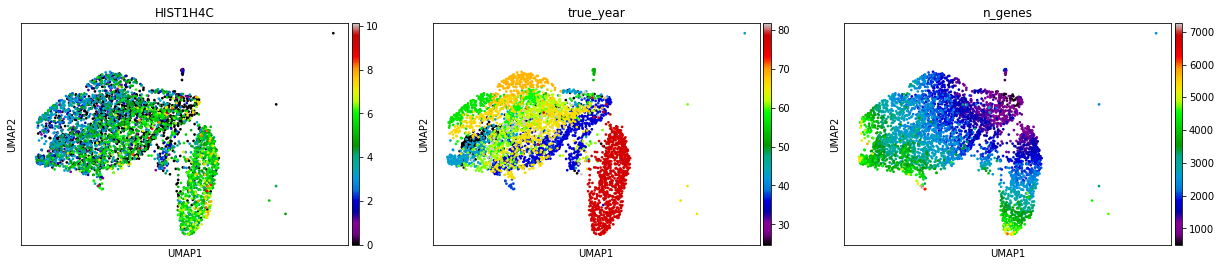

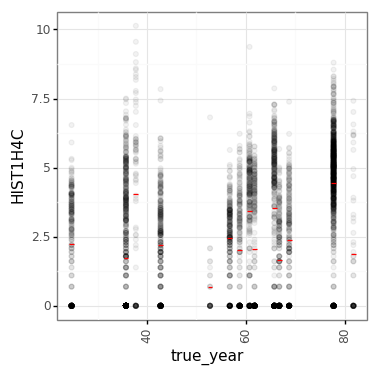

<ggplot: (8752287615976)>
querying 1-1...done.
Finished.
0:  HIST1H4C 
 Histones are basic nuclear proteins that are responsible for the nucleosome structure of the chromosomal fiber in eukaryotes. Two molecules of each of the four core histones (H2A, H2B, H3, and H4) form an octamer, around which approximately 146 bp of DNA is wrapped in repeating units, called nucleosomes. The linker histone, H1, interacts with linker DNA between nucleosomes and functions in the compaction of chromatin into higher order structures. This gene is intronless and encodes a replication-dependent histone that is a member of the histone H4 family. Transcripts from this gene lack polyA tails but instead contain a palindromic termination element. This gene is found in the large histone gene cluster on chromosome 6. [provided by RefSeq, Aug 2015].


In [150]:
# look up gene

gene = 'HIST1H4C'
groupby = 'patient'

sc.pl.umap(input_adata, color = [gene, 'true_year', 'n_genes'], cmap='nipy_spectral')

cat, plot_df = prepare_dataframe(input_adata,
                            gene,
                            groupby
                           )
plot_df['true_year'] =  input_adata.obs.true_year.tolist()
plotnine.options.figure_size = (4,4)
print(ggplot(plot_df)
      + theme_bw()
      + theme(axis_text_x = element_text(angle = 90))
      + geom_point(aes('true_year',gene), alpha = 0.05)
      + geom_point(plot_df.reset_index().groupby('patient').mean(), aes('true_year',gene), 
                   shape = '_', color = 'red')
     )

out = symbol2field(gene)
output = [print(f'{idx}: ', 
       x['query'],
       '\n',x['summary']) if ('summary' in x.keys()) else print(f'{idx}: ', 
                                                                x['query'],
                                                                '\n','N/A') for idx, x in enumerate(out)]

# DEV: ridge plots

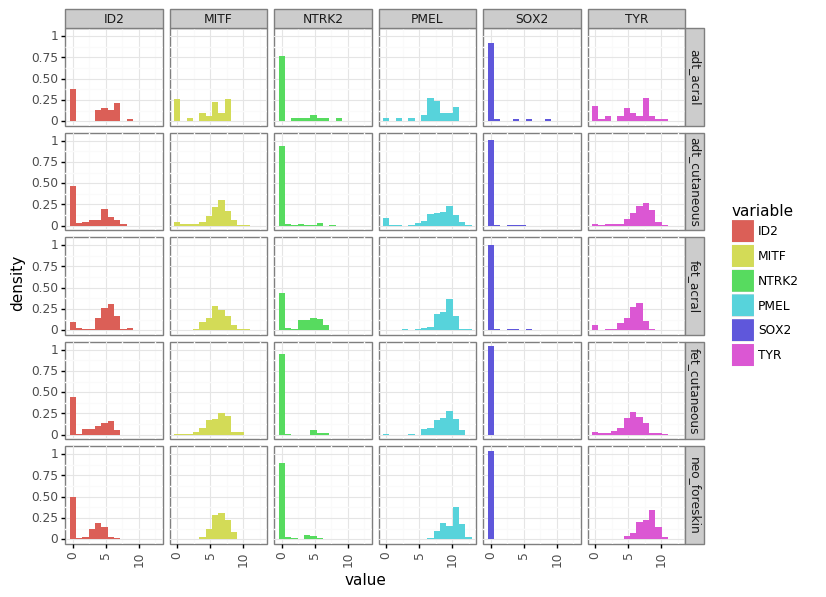

<ggplot: (8752279271663)>


In [119]:
# "ridge plots"
#####################
genelist = ['SOX2','MITF','TYR','PMEL','NTRK2','ID2']
groupby = 'dev_subtype'
# groupby = 'dev_stage'
print_umaps = False
print_anno = False
#####################

input_adata = adata_subset2
cat, plot_df = prepare_dataframe(input_adata,
                            genelist,
                            groupby
                           )
plot_df = plot_df.reset_index()
plot_df = pd.melt(plot_df, id_vars=groupby)
plot_df = plot_df.sample(frac = 0.1)

plotnine.options.figure_size = (8,8)
print(ggplot(plot_df)
      + theme_bw()
      + theme(axis_text_x = element_text(angle = 90),
              aspect_ratio = 1
             )
      + facet_grid(f'{groupby} ~ variable')
      + geom_histogram(aes('value',"..density..", fill='variable'))
     )

if print_umaps == True:
    sc.pl.umap(input_adata, color = [groupby]+genelist, cmap='nipy_spectral', 
               palette = 'tab20', legend_loc = 'on data', ncols = 3)

if print_anno == True:
    out = symbol2field(genelist)
    output = [print(f'{idx}: ', 
           x['query'],
           '\n',x['summary']) if ('summary' in x.keys()) else print(f'{idx}: ', 
                                                                    x['query'],
                                                                    '\n','N/A') for idx, x in enumerate(out)]


# DEV: Cancer correlation

- TODO: log1p transform and refactor for extensibility

### Correlation to bulk melanoma cell lines

#### Bulkized ranked correlation

download: s3://daniel.le-work/MEL_project/acraldata.MvA.counts.csv to ../../data/DL20181011_melanocyte_test_data/acraldata.MvA.counts.csv


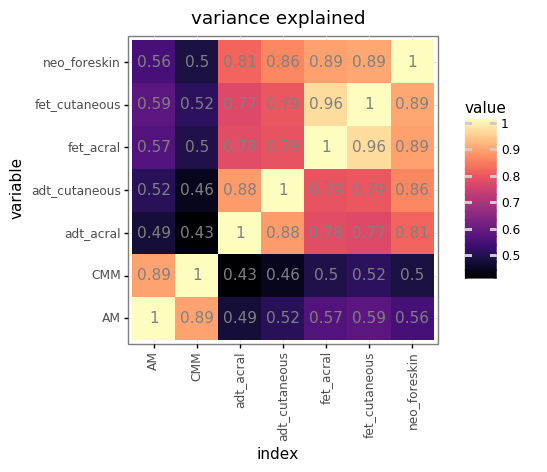

<ggplot: (-9223363308871460415)>


In [56]:
# download raw data from s3
wkdir, s3dir = '/home/ubuntu/data/DL20181011_melanocyte_test_data', 'daniel.le-work/MEL_project'

# import data from s3
for file in ['acraldata.MvA.counts.csv']:
    ! aws s3 cp s3://{s3dir}/{file} {wkdir}/

compare_adata = adata_subset2
cell_line_df = pd.read_csv('/home/ubuntu/data/DL20181011_melanocyte_test_data/acraldata.MvA.counts.csv',
                           index_col=0)
cell_line_df.columns = [x.replace('-','_') for x in cell_line_df.columns]
cell_line_df = (cell_line_df.set_index(pd.Index([x.split(' ')[0] for x in cell_line_df.index]))
                .sort_index())
# match genes to adata
cell_line_df = cell_line_df[[x in compare_adata.var_names.tolist() for x in cell_line_df.index]]
cell_line_df = cell_line_df.apply(np.log1p)
# remove duplicate gene
cell_line_df = cell_line_df[~cell_line_df.index.duplicated(keep='first')]
cell_line_df = cell_line_df.T
cell_line_df['cancer_origin'] = ['CMM' if x.startswith('1205LU') or x.startswith('SKMEL') else 'AM' for x in cell_line_df.index]
cell_line_df = cell_line_df.set_index('cancer_origin')
cell_line_df = (cell_line_df
                .reset_index()
                .groupby('cancer_origin')
                .mean()
                .T
                .reset_index()
               )

# return only genes found in both sets
cat, gene_df = prepare_dataframe(adata_subset2,
                         cell_line_df['index'].tolist(),
                         'dev_subtype')
gene_df = (gene_df
           .reset_index())
gene_df['dev_subtype'] = gene_df['dev_subtype'].astype(str)
gene_df = (gene_df
           .groupby('dev_subtype')
           .mean()
           .T
           .reset_index()
          )

cross_merge = pd.merge(cell_line_df, gene_df, 'inner', 'index')
cross_merge = cross_merge.corr(method = 'spearman')**2
cross_merge = cross_merge.reset_index()
cross_melt = pd.melt(cross_merge, id_vars='index')
cross_melt['val_label'] = [f'{x:.2g}' for x in cross_melt['value']]
plotnine.options.figure_size = (4,4)
print(ggplot(cross_melt)
      + theme_bw()
      + theme(axis_text_x = element_text(angle = 90))
      + geom_tile(aes('index','variable',fill='value'))
      + geom_text(aes('index','variable',label='val_label'), color = 'grey')
      + scale_fill_cmap('magma')
      + ggtitle('variance explained')
     )

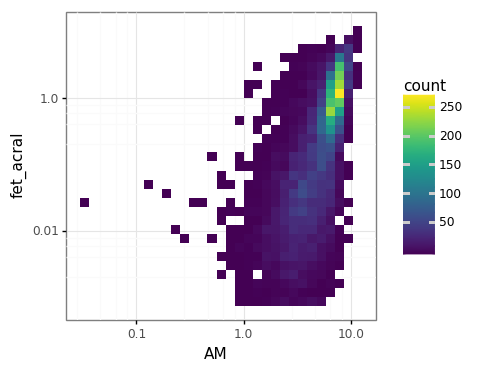

<ggplot: (8744058232584)>


In [14]:
# example correlated expression plot
cross_merge = pd.merge(cell_line_df, gene_df, 'inner', 'index')
print(ggplot(cross_merge)
      + theme_bw()
      + geom_bin2d(aes('AM','fet_acral'))
      + scale_x_log10()
      + scale_y_log10()
     )


#### Single cell ranked correlation

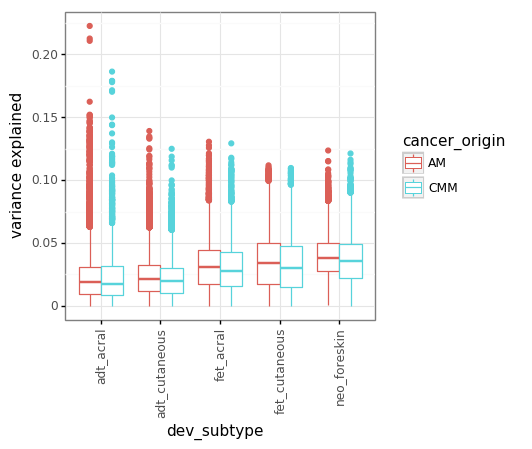

<ggplot: (8758481982044)>


In [14]:
# compare_adata = adata_subset2
# cell_line_df = pd.read_csv('/home/ubuntu/data/DL20181011_melanocyte_test_data/acraldata.MvA.counts.csv',
#                            index_col=0)
# cell_line_df.columns = [x.replace('-','_') for x in cell_line_df.columns]
# cell_line_df = (cell_line_df.set_index(pd.Index([x.split(' ')[0] for x in cell_line_df.index]))
#                 .sort_index())
# # match genes to adata
# cell_line_df = cell_line_df[[x in compare_adata.var_names.tolist() for x in cell_line_df.index]]
# cell_line_df = cell_line_df.apply(np.log1p)
# # remove duplicate gene
# cell_line_df = cell_line_df[~cell_line_df.index.duplicated(keep='first')]
# cell_line_df = cell_line_df.T

# # return only genes found in both sets
# cat, gene_df = prepare_dataframe(adata_subset2,
#                          cell_line_df.columns.tolist(),
#                          'dev_subtype')

# # create empty return arrays
# stat_array = np.zeros((len(cell_line_df), len(gene_df)))
# pval_array = np.zeros((len(cell_line_df), len(gene_df)))

# # run parallel spearman
# ## create arguments list
# gene_df_index = [x for x in range(len(gene_df))]
# index_len = len(gene_df_index)
# # index_len = 10

# ## run
# p = multiprocessing.Pool(processes=7)

# try:
#     results = p.map(parallel_paired_spearman, 
#                             zip(gene_df_index[:index_len], 
#                                 [gene_df]*index_len, 
#                                 [cell_line_df]*index_len,
#                                 [True]*index_len),
#                             chunksize=100)
# finally:
#     p.close()
#     p.join()

# # recast results into arrays
# for result, idx in zip(results, gene_df_index):
#     stat_array[:,idx] = result[0]
#     pval_array[:,idx] = result[1]

# # recast array in df
# stat_df = pd.DataFrame(stat_array**2)
# stat_df.columns = compare_adata.obs.index.tolist()
# stat_df = stat_df.set_index(cell_line_df.index)
# stat_df = stat_df.T.reset_index()
# stat_df = pd.melt(stat_df, id_vars='index')
# stat_df = pd.merge(stat_df, 
#                    compare_adata.obs.loc[:,['dev_subtype']].reset_index(),
#                   'left','index')
# stat_df['cancer_origin'] = ['CMM' if x.startswith('1205LU') or x.startswith('SKMEL') else 'AM' for x in stat_df['variable']]

# # variance explained distributions
# plotnine.options.figure_size = (4,4)
# print(ggplot(stat_df)
#       + theme_bw()
#       + theme(axis_text_x = element_text(angle = 90))
#       + geom_boxplot(aes('dev_subtype','value', color = 'cancer_origin'))
#       + labs(y='variance explained')
#      )


#### Analysis of bulk melanoma cell line gene expression
prioritize fet/neo DE genes  vs cancer DE genes

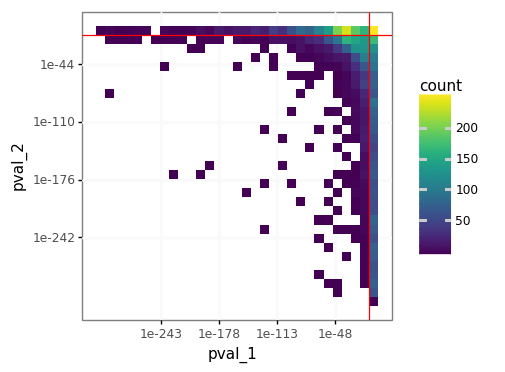

<ggplot: (-9223363292791707872)>


,gene,stat_1,pval_1,stat_2,pval_2,nz_count
5109,QPRT,6887777.5,0.0,54440.0,2.204982e-03,3228
5752,SLC25A5,7133269.0,0.0,63835.5,1.855577e-07,4670
2888,IER2,6878029.0,0.0,65005.0,3.673685e-08,2721
2915,IGFBP3,6802931.0,0.0,44438.5,4.376166e-01,1998
1854,EGR1,6472236.0,0.0,51951.0,1.160616e-02,2292
5131,RAB3B,6130786.0,0.0,39929.5,7.715294e-01,1481
528,ATP1B1,1811415.5,0.0,19221.0,4.552895e-10,2935
1407,CREB5,6159465.0,0.0,40300.0,8.439959e-01,1644
3335,LGALS3,1290386.0,0.0,18441.0,1.226519e-07,4764
1325,COL1A2,6602150.0,0.0,48951.0,6.686746e-02,2140


In [15]:
compare_adata = adata_subset2
cell_line_df = pd.read_csv('/home/ubuntu/data/DL20181011_melanocyte_test_data/acraldata.MvA.counts.csv',
                           index_col=0)
cell_line_df.columns = [x.replace('-','_') for x in cell_line_df.columns]
cell_line_df = (cell_line_df.set_index(pd.Index([x.split(' ')[0] for x in cell_line_df.index]))
                .sort_index())
# match genes to adata
cell_line_df = cell_line_df[[x in compare_adata.var_names.tolist() for x in cell_line_df.index]]
cell_line_df = cell_line_df.apply(np.log1p)
# remove duplicate gene
cell_line_df = cell_line_df[~cell_line_df.index.duplicated(keep='first')]
cell_line_df = cell_line_df.T

# return only genes found in both sets
genes = cell_line_df.columns.tolist()

# create fet/neo subset and adt subset
cat, gene_df = prepare_dataframe(adata_subset2,
                         genes,
                         'dev_subtype')
fet_neo_cells = gene_df[[x.startswith('neo') or x.startswith('fet') for x in gene_df.index.astype(str)]]
adt_cells = gene_df[[x.startswith('adt') for x in gene_df.index.astype(str)]]

# mwu test: adt vs fet/neo
stat_pval_tuple = parallel_mwu(genes, 
                               fet_neo_cells.rank(pct=True, axis = 1, method = 'min'), 
                               adt_cells.rank(pct=True, axis = 1, method = 'min'), 
                               'two-sided', 
                               7)
stat_list = stat_pval_tuple[0]
pval_list = stat_pval_tuple[1]
mwu_df1 = (pd.DataFrame({'gene':genes,
                         'stat_1':stat_list,
                         'pval_1':pval_list
                        })
          )

# mwu test: fet/neo vs cancer
stat_pval_tuple = parallel_mwu(genes, 
                               fet_neo_cells.rank(pct=True, axis = 1, method = 'min'), 
                               cell_line_df.rank(pct=True, axis = 1, method = 'min'), 
                               'two-sided', 
                               7)
stat_list = stat_pval_tuple[0]
pval_list = stat_pval_tuple[1]
mwu_df2 = (pd.DataFrame({'gene':genes,
                         'stat_2':stat_list,
                         'pval_2':pval_list
                        })
          )

# compile results in df
de_rank = pd.merge(mwu_df1, mwu_df2, 'inner', 'gene')
de_rank = pd.merge(de_rank,
                   pd.DataFrame(gene_df.astype(bool).sum(axis=0)).reset_index().rename(columns = {'index':'gene',0:'nz_count'}),
                   'left',
                   'gene'
                  )

alpha = 0.05
adj_crit = alpha / (len(cell_line_df) * len(fet_neo_cells) * len(genes))
print(ggplot(de_rank)
      + theme_bw()
      + geom_bin2d(aes('pval_1','pval_2'))
      + geom_hline(aes(yintercept=adj_crit),color ='red')
      + geom_vline(aes(xintercept=adj_crit),color ='red')
      + scale_x_log10()
      + scale_y_log10()
     )

# print all rows that pass bonferroni correction procedure
de_rank[[x < adj_crit and y > adj_crit for x,y in zip(de_rank.pval_1,de_rank.pval_2)]].sort_values('pval_1').head(10)


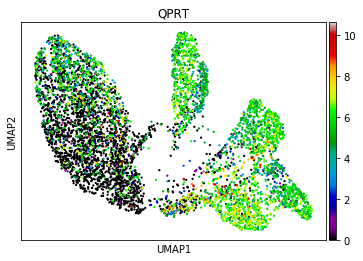

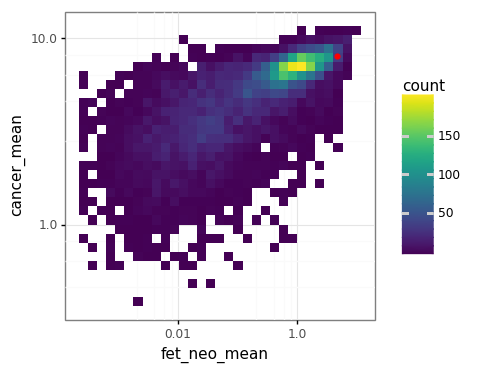

<ggplot: (-9223363292862342414)>
querying 1-1...done.
Finished.
0:  QPRT 
 This gene encodes a key enzyme in catabolism of quinolinate, an intermediate in the tryptophan-nicotinamide adenine dinucleotide pathway. Quinolinate acts as a most potent endogenous exitotoxin to neurons. Elevation of quinolinate levels in the brain has been linked to the pathogenesis of neurodegenerative disorders such as epilepsy, Alzheimer's disease, and Huntington's disease. Alternative splicing results in multiple transcript variants. [provided by RefSeq, Dec 2015].


In [19]:
# look up gene

gene = 'QPRT'

sc.pl.umap(adata_subset2, color = [gene], cmap='nipy_spectral')

plot_df = pd.DataFrame({'cancer_mean':cell_line_df.mean().values,
                        'fet_neo_mean':fet_neo_cells.mean(),
                        'gene':genes
             })
plot_df['label'] = [x == gene for x in plot_df.gene]
print(ggplot(plot_df)
      + theme_bw()
      + geom_bin2d(aes('fet_neo_mean','cancer_mean'))
      + geom_point(plot_df[plot_df.label == True], aes('fet_neo_mean','cancer_mean'), color = 'red')
      + scale_x_log10()
      + scale_y_log10()
     )

out = symbol2field(gene)
output = [print(f'{idx}: ', 
       x['query'],
       '\n',x['summary']) if ('summary' in x.keys()) else print(f'{idx}: ', 
                                                                x['query'],
                                                                '\n','N/A') for idx, x in enumerate(out)]

### Correlate to single cell melanoma biopsies
neo_foreskin exhibits highest correlation to cancer

#### Bulkized ranked correlation

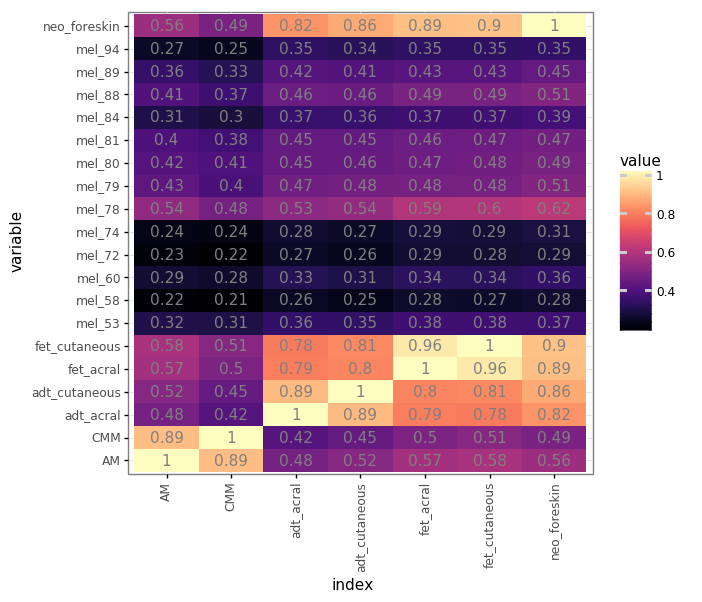

<ggplot: (8758472681757)>


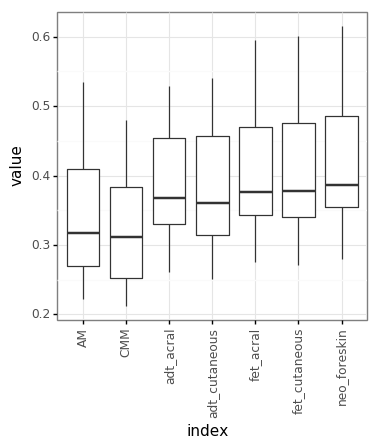

<ggplot: (-9223363278368435694)>


In [17]:
# correlations on means
# cell line counts table and filter by genes in sc data
compare_adata = adata_subset2
cell_line_df = pd.read_csv('/home/ubuntu/data/DL20181011_melanocyte_test_data/acraldata.MvA.counts.csv',
                           index_col=0)
cell_line_df.columns = [x.replace('-','_') for x in cell_line_df.columns]
cell_line_df = (cell_line_df.set_index(pd.Index([x.split(' ')[0] for x in cell_line_df.index]))
                .sort_index())
cell_line_df = cell_line_df[[x in compare_adata.var_names.tolist() for x in cell_line_df.index]]
cell_line_df = cell_line_df.apply(np.log1p)
# remove duplicate gene
cell_line_df = cell_line_df[~cell_line_df.index.duplicated(keep='first')]
cell_line_df = cell_line_df.T
cell_line_df['cancer_origin'] = ['CMM' if x.startswith('1205LU') or x.startswith('SKMEL') else 'AM' for x in cell_line_df.index]
cell_line_df = cell_line_df.set_index('cancer_origin')
cell_line_df = (cell_line_df
                .reset_index()
                .groupby('cancer_origin')
                .mean()
                .T
                .reset_index()
               )

# mean single cell patient melanoma
sc_mel_df = pd.read_csv('/home/ubuntu/data/DL20181011_melanocyte_test_data/cancer_ext_data/GSE72056_melanoma_single_cell_revised_v2.txt',
           sep = '\t')

sc_mel_counts = (sc_mel_df.iloc[3:,:]
                 .rename(columns = {'Cell':'gene'})
                 .set_index('gene')
                 .T
                )
sc_mel_counts['cancer_patient'] = ['mel_{}'.format(int(x)) for x in sc_mel_df.iloc[0,1:]]
# filter based on Fig1C constituents from paper
mel_cell_id = [53,58,60,72,74,78,79,80,81,84,88,89,94]
sc_mel_counts = sc_mel_counts[[int(x.split('_')[1]) in mel_cell_id for x in sc_mel_counts.cancer_patient]]
sc_mel_counts = (sc_mel_counts
                 .groupby('cancer_patient')
                 .mean()
                 .T
                 .reset_index()
                 .rename(columns = {'gene':'index'}))

cancers_df = pd.merge(cell_line_df, sc_mel_counts, 'inner', 'index')

# primary single cell
cat, gene_df = prepare_dataframe(adata_subset2,
                         cancers_df['index'].tolist(),
                         'dev_subtype')
gene_df = (gene_df
           .reset_index())
gene_df['dev_subtype'] = gene_df['dev_subtype'].astype(str)
gene_df = (gene_df
           .groupby('dev_subtype')
           .mean()
           .T
           .reset_index()
          )

# merge primary and melanoma
cross_merge = pd.merge(cancers_df, gene_df, 'inner', 'index')
cross_merge = cross_merge.corr(method = 'spearman')**2
cross_merge = cross_merge.reset_index()
cross_melt = pd.melt(cross_merge, id_vars='index')
cross_melt['val_label'] = [f'{x:.2g}' for x in cross_melt['value']]
plotnine.options.figure_size = (6,6)
print(ggplot(cross_melt[[not x.startswith('mel_') for x in cross_melt['index']]])
      + theme_bw()
      + theme(axis_text_x = element_text(angle = 90))
      + geom_tile(aes('index','variable',fill='value'))
      + geom_text(aes('index','variable',label='val_label'), color = 'grey')
      + scale_fill_cmap('magma')
     )

filtered_cross_merge = cross_merge.loc[:,['index']+[x for x in cross_merge.columns if x.startswith('mel_')]]
filtered_cross_merge = filtered_cross_merge[[not x.startswith('mel_') for x in filtered_cross_merge['index']]]
filtered_cross_merge = pd.melt(filtered_cross_merge, id_vars='index')
plotnine.options.figure_size = (4,4)
print(ggplot(filtered_cross_merge)
      + theme_bw()
      + theme(axis_text_x = element_text(angle = 90))
      + geom_boxplot(aes('index','value'))
     )



#### Single cell ranked correlation

In [ ]:
# ## correlate with cancer manuscript raw data: http://science.sciencemag.org/content/352/6282/189
# # accession numbers GSE72056 and GSE77940
# # contains tumor cell counts table: https://www.ncbi.nlm.nih.gov/geo/query/acc.cgi?acc=GSE72056
# sc_mel_df = pd.read_csv('/home/ubuntu/data/DL20181011_melanocyte_test_data/cancer_ext_data/GSE72056_melanoma_single_cell_revised_v2.txt',
#            sep = '\t')

# sc_mel_counts = (sc_mel_df.iloc[3:,:]
#                  .rename(columns = {'Cell':'gene'})
#                  .set_index('gene')
#                  .T
#                 )

# # filter by adata gene list and remove duplicate genes
# gene_count = pd.DataFrame({'gene':sc_mel_counts.columns})['gene'].value_counts()
# sc_mel_counts = sc_mel_counts.drop(gene_count[gene_count > 1].index.tolist(), axis = 1)
# sc_mel_counts = sc_mel_counts.loc[:,[x for x in adata_subset2.var_names.tolist() if x in sc_mel_counts.columns.tolist()]]

# # meta key
# ## malignant(1=no,2=yes,0=unresolved)
# ## non-malignant cell type (1=T,2=B,3=Macro.4=Endo.,5=CAF;6=NK)
# sc_mel_meta = (sc_mel_df
#                .iloc[:3,:]
#                .set_index('Cell')
#                .T
#                .rename(columns = {'malignant(1=no,2=yes,0=unresolved)':'malignant',
#                                  'non-malignant cell type (1=T,2=B,3=Macro.4=Endo.,5=CAF;6=NK)':'celltype'
#                                  })
#                .astype(int)
#               )

# # filter by meta data to only mel cells of interest
# mel_cell_id = [53,58,60,72,74,78,79,80,81,84,88,89,94]
# filtered_cell_names = sc_mel_meta[[x == 2 and y in mel_cell_id and z == 0 for x,y,z in zip(sc_mel_meta.malignant, 
#                                                         sc_mel_meta.tumor, 
#                                                         sc_mel_meta.celltype)
#             ]
#            ].index.tolist()

# sc_mel_counts = sc_mel_counts[[x in filtered_cell_names for x in sc_mel_counts.index]]

# # return only genes found in both sets
# cat, gene_df = prepare_dataframe(adata_subset2,
#                          sc_mel_counts.columns.tolist(),
#                          'dev_subtype')
    
# # create empty return arrays
# stat_array = np.zeros((len(sc_mel_counts), len(gene_df)))
# pval_array = np.zeros((len(sc_mel_counts), len(gene_df)))

# # run parallel spearman
# # create arguments list
# gene_df_index = [x for x in range(len(gene_df))]
# index_len = len(gene_df_index)

# ## run
# p = multiprocessing.Pool(processes=7)

# try:
#     results = p.map(parallel_paired_spearman, 
#                             zip(gene_df_index[:index_len], 
#                                 [gene_df]*index_len, 
#                                 [sc_mel_counts]*index_len,
#                                 [True]*index_len),
#                             chunksize=100)
# finally:
#     p.close()
#     p.join()

# # recast results into arrays
# for result, idx in zip(results, gene_df_index):
#     stat_array[:,idx] = result[0]
#     pval_array[:,idx] = result[1]

# # recast array in df
# stat_df = pd.DataFrame(stat_array**2)
# stat_df.columns = adata_subset2.obs.index.tolist()
# stat_df = stat_df.set_index(sc_mel_counts.index)
# stat_df = stat_df.T.reset_index()
# stat_df = pd.melt(stat_df, id_vars='index')
# stat_df = pd.merge(stat_df, 
#                    adata_subset2.obs.loc[:,['dev_subtype']].reset_index(),
#                   'left','index')

# # variance explained distributions
# plotnine.options.figure_size = (5,5)
# print(ggplot(stat_df)
#       + theme_bw()
#       + theme(axis_text_x = element_text(angle = 90))
#       + geom_boxplot(aes('dev_subtype','value'))
#       + labs(y='variance explained')
#      )

#### Analysis of single cell melanoma biopsy gene expression
prioritize neo DE genes  vs cancer DE genes

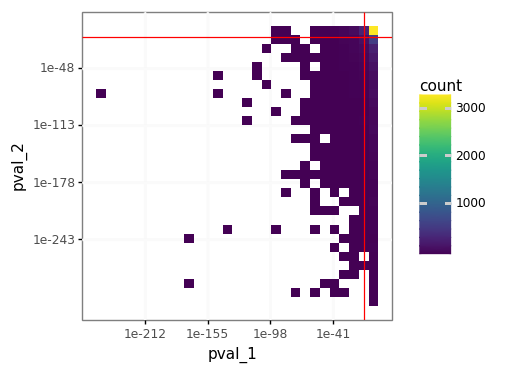

<ggplot: (8758428283968)>


,gene,stat_1,pval_1,stat_2,pval_2,nz_count
971,FADS2,1051031.0,1.199474e-97,1570304.0,6.907534e-08,2395
5304,CD200,2224950.0,3.620959e-93,1749982.5,1.627942e-02,409
1093,NQO1,2478340.5,1.461225e-90,1667782.5,6.745528e-01,1386
3018,ECM1,1063999.5,2.091825e-87,1577764.5,1.012822e-04,2818
5130,MICA,2362896.0,1.405313e-77,1908303.5,1.652630e-11,1017
4098,TANGO2,2446758.5,1.439565e-61,1671231.0,7.449408e-01,2148
5012,COL4A2,1264201.0,8.298733e-60,1647397.5,5.449643e-02,1932
5076,LMO2,1954945.0,1.070251e-50,1759795.0,7.754920e-13,63
944,FXYD3,1306785.5,7.946238e-50,1518280.0,1.384897e-09,2046
6506,TCTA,2338719.0,2.729894e-49,1472244.5,4.039082e-08,1664


In [37]:
# return only genes found in both sets
sc_mel_df = pd.read_csv('/home/ubuntu/data/DL20181011_melanocyte_test_data/cancer_ext_data/GSE72056_melanoma_single_cell_revised_v2.txt',
           sep = '\t')

sc_mel_counts = (sc_mel_df.iloc[3:,:]
                 .rename(columns = {'Cell':'gene'})
                 .set_index('gene')
                )
sc_mel_counts = sc_mel_counts[~sc_mel_counts.index.duplicated(keep='first')]
sc_mel_counts = sc_mel_counts.T
keep_genes = list(set(adata_subset2.var_names) & set(sc_mel_counts.columns))
sc_mel_counts = sc_mel_counts.loc[:,keep_genes]

cat, gene_df = prepare_dataframe(adata_subset2,
                         keep_genes,
                         'dev_subtype')
neo_cells = gene_df[[x.startswith('neo') for x in gene_df.index.astype(str)]]
other_cells = gene_df[[not x.startswith('neo') for x in gene_df.index.astype(str)]]

# mwu test: neo vs rest
stat_pval_tuple = parallel_mwu(keep_genes, 
                               neo_cells.rank(pct=True, axis = 1, method = 'min'), 
                               other_cells.rank(pct=True, axis = 1, method = 'min'), 
                               'two-sided',
                               7)
stat_list = stat_pval_tuple[0]
pval_list = stat_pval_tuple[1]
mwu_df1 = (pd.DataFrame({'gene':keep_genes,
                         'stat_1':stat_list,
                         'pval_1':pval_list
                        })
          )

# mwu test: neo vs cancer
stat_pval_tuple = parallel_mwu(genes, 
                               neo_cells.rank(pct=True, axis = 1, method = 'min'), 
                               sc_mel_counts.rank(pct=True, axis = 1, method = 'min'), 
                               'two-sided', 
                               7)
stat_list = stat_pval_tuple[0]
pval_list = stat_pval_tuple[1]
mwu_df2 = (pd.DataFrame({'gene':genes,
                         'stat_2':stat_list,
                         'pval_2':pval_list
                        })
          )

# compile results in df
de_rank = pd.merge(mwu_df1, mwu_df2, 'inner', 'gene')
de_rank = pd.merge(de_rank,
                   pd.DataFrame(gene_df.astype(bool).sum(axis=0)).reset_index().rename(columns = {'index':'gene',0:'nz_count'}),
                   'left',
                   'gene'
                  )

alpha = 0.05
adj_crit = alpha / (len(cell_line_df) * len(fet_neo_cells) * len(genes))
print(ggplot(de_rank)
      + theme_bw()
      + geom_bin2d(aes('pval_1','pval_2'))
      + geom_hline(aes(yintercept=adj_crit),color ='red')
      + geom_vline(aes(xintercept=adj_crit),color ='red')
      + scale_x_log10()
      + scale_y_log10()
     )

# print all rows that pass bonferroni correction procedure
de_rank[[x < adj_crit and y > adj_crit for x,y in zip(de_rank.pval_1,de_rank.pval_2)]].sort_values('pval_1').head(10)


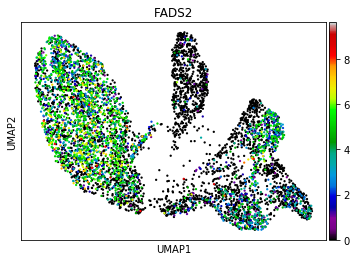

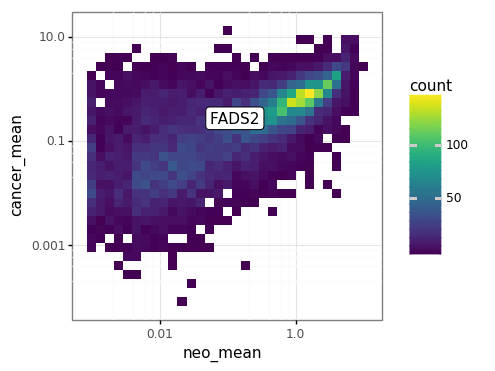

<ggplot: (8758473887394)>
querying 1-1...done.
Finished.
0:  FADS2 
 The protein encoded by this gene is a member of the fatty acid desaturase (FADS) gene family. Desaturase enzymes regulate unsaturation of fatty acids through the introduction of double bonds between defined carbons of the fatty acyl chain. FADS family members are considered fusion products composed of an N-terminal cytochrome b5-like domain and a C-terminal multiple membrane-spanning desaturase portion, both of which are characterized by conserved histidine motifs. This gene is clustered with family members at 11q12-q13.1; this cluster is thought to have arisen evolutionarily from gene duplication based on its similar exon/intron organization. Alternative splicing results in multiple transcript variants encoding different isoforms. [provided by RefSeq, Jul 2013].


In [39]:
# look up gene

gene = 'FADS2'

sc.pl.umap(adata_subset2, color = [gene], cmap='nipy_spectral')

plot_df = pd.DataFrame({'cancer_mean':sc_mel_counts.mean().values,
                        'neo_mean':neo_cells.mean(),
                        'gene':keep_genes
             })
plot_df['label'] = [x == gene for x in plot_df.gene]
print(ggplot(plot_df)
      + theme_bw()
      + geom_bin2d(aes('neo_mean','cancer_mean'))
      + geom_label(plot_df[plot_df.label == True], aes('neo_mean','cancer_mean',label = 'gene'))
      + scale_x_log10()
      + scale_y_log10()
     )

out = symbol2field(gene)
output = [print(f'{idx}: ', 
       x['query'],
       '\n',x['summary']) if ('summary' in x.keys()) else print(f'{idx}: ', 
                                                                x['query'],
                                                                '\n','N/A') for idx, x in enumerate(out)]

# DEV: cellphone db testing

In [ ]:
# create new classes
full_adata.obs['dev_stage'] = ['adt' if x > 0 else 'neo' if x == 0 else 'fet' for x in full_adata.obs.age]
full_adata.obs['subtypes'] = [x if x in ['acral','foreskin'] else 'cutaneous' for x in full_adata.obs.general_location]
full_adata.obs['dev_subtype'] = [f'{x}_{y}' for x,y in zip(full_adata.obs.dev_stage, full_adata.obs.subtypes)]
full_adata.obs['dev_subtype_celltype'] = [f'{x}_{y}' for x,y in zip(full_adata.obs['dev_subtype'], full_adata.obs['class_1'])]
full_adata.obs['dev_subtype_celltype'] = full_adata.obs['dev_subtype_celltype'].astype(str).astype(CategoricalDtype(list(set(full_adata.obs['dev_subtype_celltype']))))
set(full_adata.obs['dev_subtype_celltype'])


In [ ]:
def calc_pct_expr(col):
    return np.sum(col)/len(col)

# cellphone db methods:
# ref: https://www.nature.com/articles/s41586-018-0698-6#Sec9
# >10% ligand and receptor in cell types
# permutation test te determine p-value
# HOWEVER: https://digitalcommons.wayne.edu/cgi/viewcontent.cgi?referer=https://www.google.com/&httpsredir=1&article=1479&context=jmasm
# above authors show, using simulations, that WMU test has higher power (ability to correctly reject null)

# input adata
alpha = 0.1
input_adata = full_adata
feature_axis = 'class_1' # must be binary!
classes = ['MEL', 'KRT']
input_adata = input_adata[[x in classes for x in input_adata.obs[feature_axis]]]

# cast counts data
cat, gene_df = prepare_dataframe(input_adata,
                         input_adata.var_names,
                         feature_axis)

# pull interactions list
interact_df = pd.read_csv('s3://daniel.le-work/MEL_project/DL20190307_interactions_cellphonedb.csv')
interact_df = interact_df.loc[:,['entry_name_a', 'entry_name_b']].dropna()
interact_df['entry_name_a'] = [x.split('_')[0] for x in interact_df['entry_name_a']]
interact_df['entry_name_b'] = [x.split('_')[0] for x in interact_df['entry_name_b']]

# non-zero expression df
nz_df = gene_df.astype(bool).reset_index().groupby(feature_axis).apply(calc_pct_expr)

# filter nz df by interaction genes
interaction_genes = list(set(interact_df['entry_name_a'].values.tolist() + interact_df['entry_name_b'].values.tolist()))
nz_df = (nz_df
         .loc[:,interaction_genes]
         .T
         .dropna())

# filter nz df by heuristic: pct_exp > 0.1 in both classes
nz_df = nz_df[[x >= 0.1 and y >= 0.1 for x,y in zip(nz_df[classes[0]], nz_df[classes[1]])]]
passed_genes = nz_df.index.tolist()

# filter interactions that pass heuristic
interact_df = interact_df[[x in passed_genes and y in passed_genes for x,y in zip(interact_df['entry_name_a'],interact_df['entry_name_b'])]]
interact_df['pairs'] = [f'pair_{x}' for x in range(len(interact_df))]
interact_df = pd.melt(interact_df, id_vars='pairs').sort_values('pairs')
interact_df = interact_df.drop('variable', axis = 1)
try:
    # mwu test for differential gene expression between classes
    stat_list = []
    pval_list = []
    test_count = 0
    for goi in interact_df.value:
        expr = gene_df.loc[:, [goi]].reset_index()
        c1_expr = expr[[x == classes[0] for x in expr[feature_axis]]][goi].values
        c2_expr = expr[[x == classes[1] for x in expr[feature_axis]]][goi].values
        stat,pval = stats.mannwhitneyu(c1_expr, c2_expr, alternative='two-sided')
        test_count += 1
        stat_list.append(stat)
        pval_list.append(pval)

    interact_df['intra_gene_diff'] = pval_list


    # mwu and mean ratio for differential paired gene expression within classes
    intergene_df = pd.DataFrame()
    for pair in list(set(interact_df.pairs)):
        gois = interact_df[interact_df.pairs == pair].value.values.tolist()
        goi1 = gois[0]
        goi2 = gois[1]
        expr = gene_df.loc[:, gois].reset_index()
        ratio_sign_list = []
        stat_list = []
        pval_list = []
        for class_val in classes:
            g1_expr = expr[[x == class_val for x in expr[feature_axis]]][goi1].values
            g2_expr = expr[[x == class_val for x in expr[feature_axis]]][goi2].values
            # calc ratio g1/g2
            ratio_sign = np.sign(np.mean(g1_expr) - np.mean(g2_expr))
            ratio_sign_list.append(ratio_sign)
            # calc mwu test
            stat,pval = stats.mannwhitneyu(g1_expr, g2_expr, alternative='two-sided')
            test_count += 1
            stat_list.append(stat)
            pval_list.append(pval)
        tmp_df = pd.DataFrame({'sign':ratio_sign_list,
                      'stat':stat_list,
                      'pval':pval_list,
                      'class_var':classes
                     })
        tmp_df['pairs'] = pair
        intergene_df = intergene_df.append(tmp_df)

    # parse intergene df and update interact df with pass/fail
    filter_df = pd.DataFrame()
    for pair in list(set(intergene_df.pairs)):
        slice_df = intergene_df[intergene_df.pairs == pair]
        sign_list = slice_df['sign'].values.tolist()
        pval_list = slice_df['pval'].values.tolist()
        class_list = slice_df['class_var'].values.tolist()
        filter_slice = pd.DataFrame({'pairs':[pair],
                                  'mutually_opposed':[sign_list[0] != sign_list[1]],
                                  f'intra_{class_list[0]}_diff':[pval_list[0]],
                                  f'intra_{class_list[1]}_diff':[pval_list[1]]
                                 })
        filter_df = filter_df.append(filter_slice)

    interact_df = pd.merge(interact_df, filter_df, 'left','pairs')
    # final filters: diametrically opposed expression within class, between gene pairs
    interact_df = interact_df[interact_df.mutually_opposed == True]
    # final filters: independence test between classes for each gene in pairs &
    #independence test within classes for each gene in pairs
    for pair in list(set(interact_df.pairs)):
        if np.sum((interact_df[intergene_df.pairs == pair]
                  .loc[:,[x.startswith('intra') for x in interact_df.columns]]
                  .values) < (alpha / test_count)) != 6:
            interact_df =  interact_df[interact_df.pairs != pair]
        else:
            pass

    if len(interact_df) == 0:
        raise exception
    else:
        for pair in list(set(interact_df.pairs)):
            df_slice = interact_df[interact_df.pairs == pair]
            display(df_slice)
            gois = df_slice.value.values.tolist()
            
            sc.pl.umap(input_adata, color = gois+[feature_axis], cmap = 'nipy_spectral')
            
            plot_df = gene_df.loc[:,gois].reset_index()
            plot_df = pd.melt(plot_df, id_vars=feature_axis)
            print(ggplot(plot_df)
                  + theme_bw()
            #       + geom_boxplot(aes(feature_axis, 'value', color = 'variable'))
                  + geom_jitter(aes('variable', 'value', color = 'variable'), alpha = 0.5)
                  + facet_wrap(f'~{feature_axis}', scales = 'free')
                 )
            
            out = symbol2field(gois)
            output = [print(f'{idx}: ', 
                   x['query'],
                   '\n',x['summary']) if ('summary' in x.keys()) else print(f'{idx}: ', 
                                                                            x['query'],
                                                                            '\n','N/A') for idx, x in enumerate(out)]
except:
    print('No significant interactions')
    

# DEV: KRT n_genes analysis


In [ ]:
sc.pl.umap(adata_subset1_KRT, color = ['n_genes', 'age', 'n_counts', 'KRT10'], cmap = 'nipy_spectral', ncols = 2)
krt_ngenes = adata_subset1_KRT.obs.loc[:,['n_genes','age_group']].reset_index()
cat, krt_genes = prepare_dataframe(adata_subset1_KRT, adata_subset1_KRT.var_names, 'age_bin')
krt_genes = krt_genes.reset_index()
krt_df = pd.concat([krt_genes, krt_ngenes], axis = 1)


In [ ]:
print(ggplot(krt_df)
      + theme_bw()
      + theme(axis_text_x = element_text(angle = 90))
      + geom_boxplot(aes('age_bin','n_genes'))
     )

print(ggplot(krt_df)
      + theme_bw()
      + theme(axis_text_x = element_text(angle = 90))
      + geom_boxplot(aes('age_group','n_genes'))
     )

## outlier detection on KRT subset

In [ ]:
# classify in raw adata


# PCA outlier detection
# initial PC coordinates
input_adata = adata_subset1_KRT
sc.pl.pca(input_adata, components=['1,2', '2,3','3,4'], color=['louvain'])

# cull cells using Tukey outlier threshold
df = pd.DataFrame(input_adata.obsm['X_pca'])
df.columns = ['PC_{}'.format(x) for x in range(50)]

omit_names = []
for pc in df.columns:
    Q1 = df[pc].quantile(0.25)
    Q3 = df[pc].quantile(0.75)
    IQR = Q3 - Q1
    threshold=5

    bool_idx = [((Q1 - threshold * IQR) <= x <= (Q3 + threshold * IQR)) for x in df[pc]]
    filtered = df[bool_idx]
    
    omit_names = omit_names + input_adata.obs[[x == False for x in bool_idx]].index.tolist()

print('Filtered cells: ', len(set(omit_names)))

# check where the outliers lie in original projection
input_adata.obs['outliers'] = ['outlier' if x in set(omit_names) else 'ingroup' for x in input_adata.obs.index]

# outliers among adt-mels
sc.pl.pca(input_adata, components=['1,2', '2,3','3,4','4,5',
                                   '5,6','6,7','7,8','8,9'], color=['outliers'])
sc.pl.umap(input_adata, color=['outliers'], cmap='magma')



In [ ]:
# update with krt outliers
full_adata.obs.outliers = ['outlier' if x in omit_names else y for x,y in zip(full_adata.obs.index, full_adata.obs.outliers)]

In [ ]:
sc.pl.umap(full_adata, color=['louvain','outliers','patient','TOP2A'], ncols = 2)


## Recluster all cells sans fsk

# DEV: Figure 2 notes

In [ ]:
# Figure2: compare cut fet vs cut adult
## IF - in progress by RB
## heatmap of DE genes - need to port from other notebook by DL
## Gene ontology of fet expression - Look into this by DL
# import gseapy as gp

# # Inputs
# glist = rank_df[rank_df.label == True].sort_values('pval', ascending = True).head(30).gene.tolist()
# outdir = '/home/ubuntu/data/enrichr_kegg' # your local working dir
# gene_sets = [
#             'KEGG_2016',
#             'GO_Molecular_Function_2018',
#             'GO_Biological_Process_2018',
#             'GO_Cellular_Component_2018',
#             'WikiPathways_2016'
#             ]

# # find more gene_sets here with the follow:
# # all_gene_sets = gp.get_library_name()

# # API call
# enr = gp.enrichr(gene_list = glist,
#                         description='test',
#                         gene_sets=gene_sets,
#                         outdir=f'{outdir}', 
#                         cutoff=0.5)

# # output results
# enr.results.sort_values('Adjusted P-value')


# Figure 3: acr vs cut
## IF for BDNF (NTRK2 ligand)
## acr KRT differential expession


In [ ]:
# omit fsk
raw_adata = raw_adata[[x not in ['foreskin'] for x in raw_adata.obs.general_location]]

# recluster on raw
full_adata_nofsk = process_adata(raw_adata)
pca_adata(full_adata_nofsk, num_pcs=30)
umap_adata(full_adata_nofsk, res=0.1)


In [ ]:
# PCA outlier detection
# initial PC coordinates
input_adata = full_adata_nofsk
sc.pl.pca(input_adata, components=['1,2', '2,3','3,4'], color=['louvain'])

# cull cells using Tukey outlier threshold
df = pd.DataFrame(input_adata.obsm['X_pca'])
df.columns = ['PC_{}'.format(x) for x in range(50)]

omit_names = []
for pc in df.columns:
    Q1 = df[pc].quantile(0.25)
    Q3 = df[pc].quantile(0.75)
    IQR = Q3 - Q1
    threshold=7

    bool_idx = [True if ((Q1 - threshold * IQR) <= x <= (Q3 + threshold * IQR)) else False for x in df[pc]]    
    omit_names = omit_names + input_adata.obs[[x == False for x in bool_idx]].index.tolist()

print('Filtered cells: ', len(set(omit_names)))

# check where the outliers lie in original projection
input_adata.obs['outliers'] = ['outlier' if x in set(omit_names) else 'ingroup' for x in input_adata.obs.index]

# outliers among adt-mels
sc.pl.pca(input_adata, components=['1,2', '2,3','3,4','4,5',
                                   '5,6','6,7','7,8','8,9'], color=['outliers'])
sc.pl.umap(input_adata, color=['outliers'], cmap='magma')


In [ ]:
# classify in raw adata
input_adata = full_adata_nofsk

type_dict = {'in':['ingroup'],
             'out':['outlier']}
    
classify_type(raw_adata, input_adata, 'outliers', type_dict, 'class_2')

feature_dict = {'class_2':['in']}
full_adata_nofsk_trimmed = subset_adata_v3(raw_adata,feature_dict)
adata_subset2 = process_adata(full_adata_nofsk_trimmed)
pca_adata(full_adata_nofsk_trimmed, num_pcs=30)
umap_adata(full_adata_nofsk_trimmed, res=0.1)


In [ ]:
sc.pl.umap(full_adata_nofsk_trimmed, color = ['PMEL',
                                              'KRT14',
                                              'KRT1'],ncols=2)

# DEV: Only adt and fet MEL recluster

In [ ]:
# omit fsk and krt
raw_adata_filtered = raw_adata[[x not in ['foreskin'] and y in adata_subset2.obs.index.tolist() for x,y in zip(raw_adata.obs.general_location, 
                                                                                                         raw_adata.obs.index)]]

# recluster on raw
full_adata_nofsk_krt = process_adata(raw_adata_filtered)
pca_adata(full_adata_nofsk_krt, num_pcs=10)
umap_adata(full_adata_nofsk_krt, res=0.1)
